In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

import numpy as np
import seaborn as sns

import re
import folium   
from folium.plugins import HeatMap

from geopy.geocoders import ArcGIS
from geopy.distance import distance

In [3]:
# Importação do arquivo principal
df_final = pd.read_csv("database/dadosTratados/df_final_comGeo.csv")

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      893 non-null    int64  
 1   NOME            893 non-null    object 
 2   TIPO            893 non-null    object 
 3   ENDERECO        893 non-null    object 
 4   LOCAL           893 non-null    object 
 5   PONTUACAO       893 non-null    float64
 6   NUM_COMENTARIO  893 non-null    int64  
 7   TEMPO_MIN_M     893 non-null    float64
 8   TEMPO_MAX_M     893 non-null    float64
 9   TEMPO_MIN       893 non-null    object 
 10  TEMPO_MAX       893 non-null    object 
 11  BAIRRO          893 non-null    object 
 12  LATITUDE        893 non-null    float64
 13  LONGITUDE       893 non-null    float64
dtypes: float64(5), int64(2), object(7)
memory usage: 97.8+ KB


In [4]:
# Quantificar locais de alimentação por bairro
count_bairro = df_final['BAIRRO'].value_counts()
count_filtrada = count_bairro[count_bairro > 3]

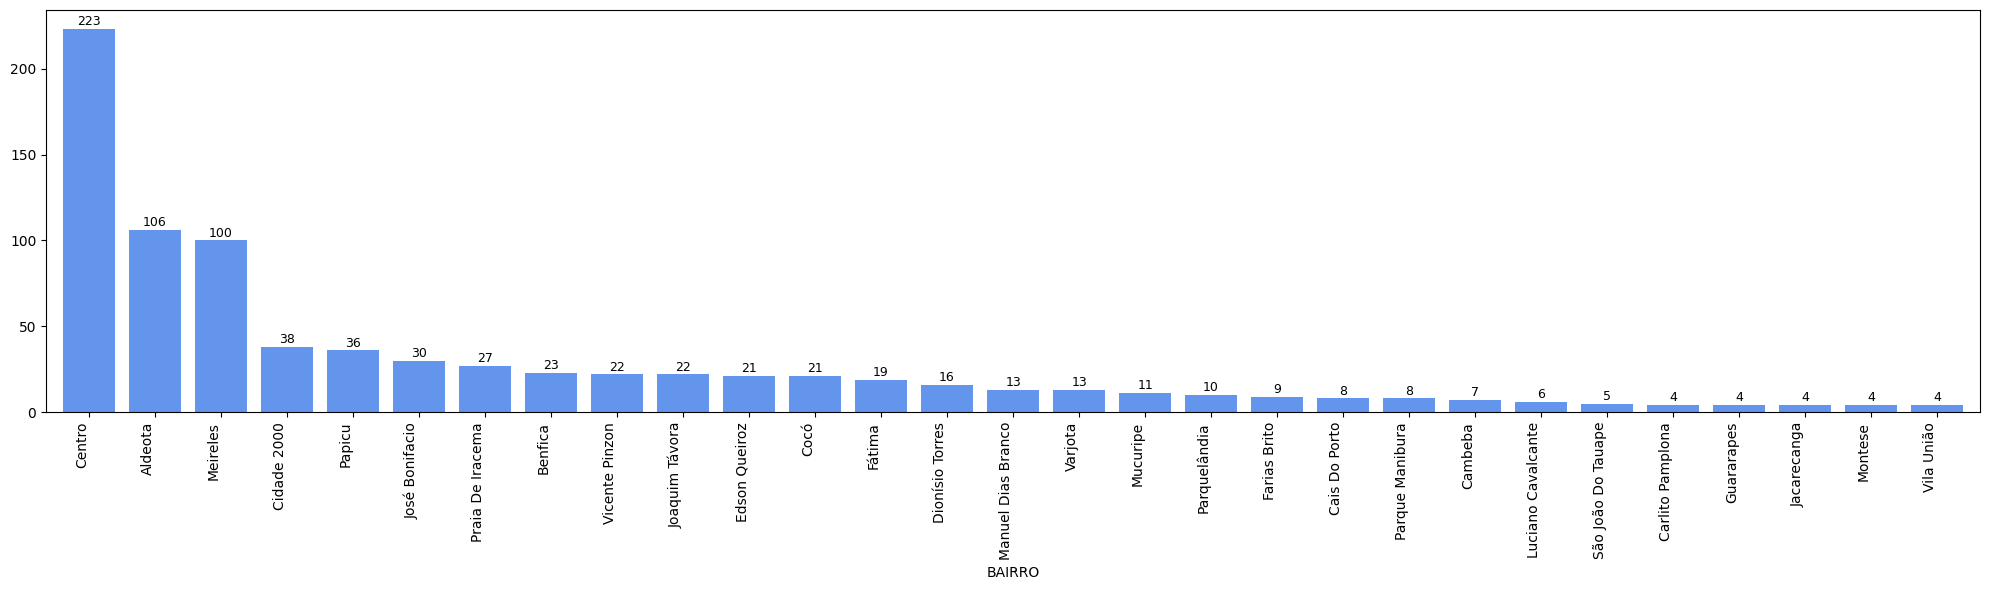

In [5]:
# Criar grafico de barras com base na quantidade de locais
plt.figure(figsize=(20,6))
ax = count_filtrada.plot(kind='bar', color='cornflowerblue', width=0.8)
for i, valor in enumerate(count_filtrada):
    ax.text(i, valor + 0.5, str(valor), ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

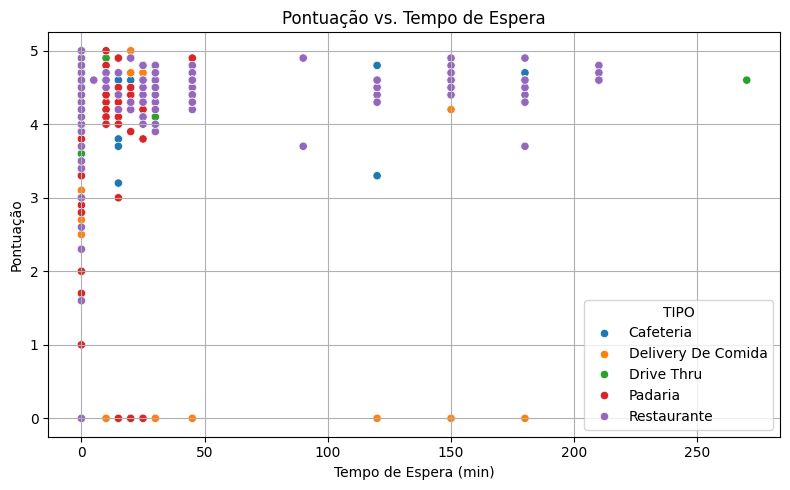

In [6]:
#Correlação entre tempo de espera min x pontuação
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_final, x='TEMPO_MIN_M', y='PONTUACAO', hue='TIPO')
plt.title('Pontuação vs. Tempo de Espera')
plt.xlabel('Tempo de Espera (min)')
plt.ylabel('Pontuação')
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Relação entre N° de Comentários e Pontuação')

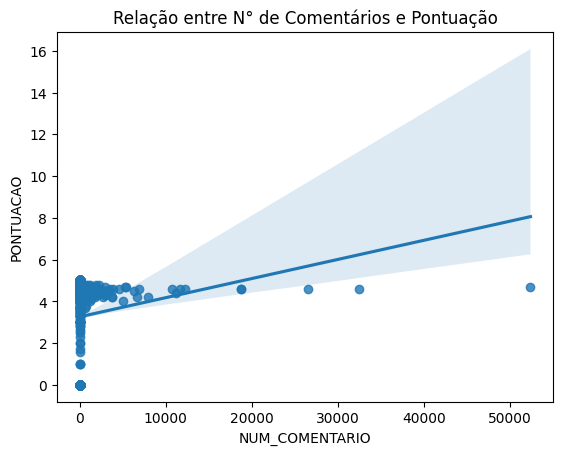

In [7]:
# Criação de grafico de correlaçao de comentario x pontuação
df_final['NUM_COMENTARIO'] = df_final['NUM_COMENTARIO'].astype(float)
sns.regplot(x='NUM_COMENTARIO', y='PONTUACAO', data=df_final)
plt.title('Relação entre N° de Comentários e Pontuação')

In [8]:
#Definição de ranking por nota (média)
nota_media = df_final.groupby('TIPO')['PONTUACAO'].mean().sort_values(ascending=False)
print(nota_media.apply(lambda x: f"{x:.2f}"))

TIPO
Restaurante           4.06
Drive Thru            4.04
Cafeteria             3.76
Padaria               3.30
Delivery De Comida    1.87
Name: PONTUACAO, dtype: object


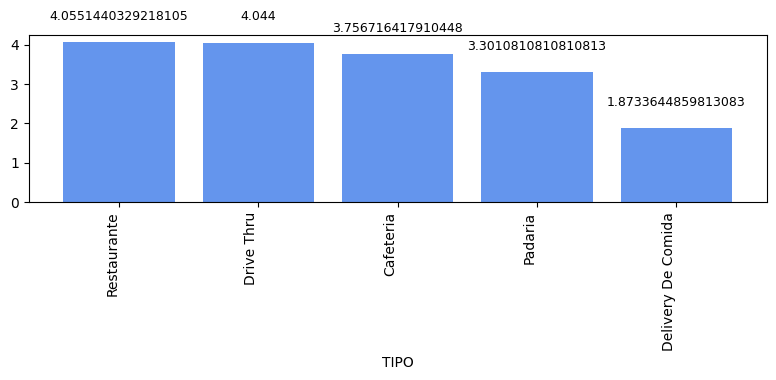

In [9]:
# Criação de gráfico com o ranking por nota (média)
plt.figure(figsize=(8,4))
ax = nota_media.plot(kind='bar', color='cornflowerblue', width=0.8)
for i, valor in enumerate(nota_media):
    ax.text(i, valor + 0.5, str(valor), ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [10]:
#criação do mapa usando ponto de referencia os dados de long e lat do bairro Centro
df_final.describe()
mapa = folium.Map(location=[-3.730061, -38.527781], zoom_start=12)
for _, row in df_final.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=row['LOCAL'],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(mapa)
#mapa

In [11]:
# Cria mapa de calor centralizado
mapa = folium.Map(location=[-3.730061, -38.527781], zoom_start=13)

# Adiciona o mapa de calor com as coordenadas
HeatMap(df_final[['LATITUDE', 'LONGITUDE']].dropna().values).add_to(mapa)
#mapa

In [12]:
# Criação de grafico com as quantidade de locais por bairro
import folium
from folium.plugins import MarkerCluster

mapa = folium.Map(location=[df_final['LATITUDE'].mean(), df_final['LONGITUDE'].mean()], zoom_start=12)
cluster = MarkerCluster().add_to(mapa)

for _, row in df_final.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=row['LOCAL'],
        icon=folium.Icon(color='green')
    ).add_to(cluster)

#mapa

In [13]:
# Criação da pesquisa do usuário e indicação no mapa
# Inicializa o geocodificador ArcGIS
geolocator = ArcGIS(timeout=10)

# Input do usuário
endereco_usuario = input("Digite o endereço: ")

# Geocodifica com ArcGIS
local = geolocator.geocode(endereco_usuario)

if not local:
    print("Endereço não encontrado.")
else:
    lat_usuario, lon_usuario = local.latitude, local.longitude
    print(f"Coordenadas: {lat_usuario}, {lon_usuario}")

    # Usa o DataFrame com latitude e longitude
    df = df_final.copy() 

    # Calcula distância até cada ponto
    def calcular_dist(row):
        return distance((lat_usuario, lon_usuario), (row['LATITUDE'], row['LONGITUDE'])).km

    df['DISTANCIA_KM'] = df.apply(calcular_dist, axis=1)

    # Filtra por raio (ex: 2 km)
    raio_km = 10
    df_proximos = df[df['DISTANCIA_KM'] <= raio_km]

    # Cria o mapa
    mapa = folium.Map(location=[lat_usuario, lon_usuario], zoom_start=15)

    # Marcador do endereço digitado
    folium.Marker(
        location=[lat_usuario, lon_usuario],
        popup='Você está aqui',
        icon=folium.Icon(color='blue')
    ).add_to(mapa)

    # Adiciona marcadores dos locais próximos
    for _, row in df_proximos.iterrows():
        folium.Marker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            popup=f"{row['NOME']} - {row['NOME']} ({row['DISTANCIA_KM']:.2f} km)",
            tooltip=row['NOME'],
            icon=folium.Icon(color='green')
        ).add_to(mapa)

    # Salva e exibe
    mapa


Coordenadas: -3.734487971362, -38.559518044936
